In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix,
                           accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
class SequentialWomenSafetyModel:
    def __init__(self):
        # Individual scalers for each stage
        self.proximity_scaler = StandardScaler()
        self.motion_scaler = StandardScaler()
        self.stress_scaler = StandardScaler()
        self.voice_scaler = StandardScaler()

        self.label_encoder = LabelEncoder()

        # Individual models for each stage
        self.proximity_model = None
        self.motion_model = None
        self.stress_model = None
        self.voice_model = None

        # Feature names for each stage
        self.proximity_features = ['proximity_distance']
        self.motion_features = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z', 'accel_magnitude', 'gyro_magnitude', 'motion_intensity']
        self.stress_features = ['gsr_level']
        self.voice_features = ['audio_amplitude', 'audio_frequency', 'voice_stress']

        # Thresholds for each stage (will be learned from data)
        self.stage_thresholds = {
            'proximity': {'safe': 5.0, 'concern': 2.0, 'danger': 1.0},
            'motion': {'safe': 0.5, 'concern': 2.0, 'danger': 4.0},
            'stress': {'safe': 60, 'concern': 100, 'danger': 150},
            'voice': {'safe': 30, 'concern': 60, 'danger': 80}
        }

    def load_csv_data(self, test_csv):
        """Load data from CSV file"""
        try:
            df = pd.read_csv('test.csv')
            print(f"Successfully loaded CSV data: {df.shape[0]} rows, {df.shape[1]} columns")

            # Verify required columns exist
            required_columns = [
                'proximity_distance', 'accel_x', 'accel_y', 'accel_z',
                'gyro_x', 'gyro_y', 'gyro_z', 'gsr_level', 'audio_amplitude',
                'audio_frequency', 'voice_stress', 'accel_magnitude',
                'gyro_magnitude', 'motion_intensity', 'threat_level'
            ]

            missing_columns = [col for col in required_columns if col not in df.columns]
            if missing_columns:
                print(f"Warning: Missing columns: {missing_columns}")
            else:
                print("All required columns found in CSV")

            # Display basic info about the dataset
            print(f"\nDataset Info:")
            print(f"Shape: {df.shape}")
            print(f"Columns: {list(df.columns)}")
            print(f"\nThreat Level Distribution:")
            print(df['threat_level'].value_counts())

            # Display basic statistics
            print(f"\nBasic Statistics:")
            print(df.describe())

            return df

        except FileNotFoundError:
            print(f"Error: CSV file '{csv_file_path}' not found.")
            return None
        except Exception as e:
            print(f"Error loading CSV: {str(e)}")
            return None

    def prepare_stage_data(self, df, stage_features):
        """Prepare data for a specific stage"""
        X = df[stage_features].copy()
        y = df['threat_level'].copy()

        # Handle missing values
        X = X.fillna(X.mean())

        # Encode labels
        y_encoded = self.label_encoder.fit_transform(y)

        return X, y_encoded

    def build_stage_models(self):
        """Build individual models for each stage"""
        # Each stage uses a different model type optimized for its purpose
        self.proximity_model = RandomForestClassifier(
            n_estimators=50, max_depth=6, random_state=42, class_weight='balanced'
        )

        self.motion_model = GradientBoostingClassifier(
            n_estimators=75, learning_rate=0.1, max_depth=5, random_state=42
        )

        self.stress_model = SVC(
            kernel='rbf', C=1.0, probability=True, random_state=42, class_weight='balanced'
        )

        self.voice_model = MLPClassifier(
            hidden_layer_sizes=(50, 25), activation='relu', max_iter=300, random_state=42
        )

    def train_stage_models(self, df):
        """Train models for each stage separately"""
        print("Training Stage 1: Proximity Detection...")
        X_prox, y_prox = self.prepare_stage_data(df, self.proximity_features)
        X_prox_scaled = self.proximity_scaler.fit_transform(X_prox)
        self.proximity_model.fit(X_prox_scaled, y_prox)

        print("Training Stage 2: Motion Analysis...")
        X_motion, y_motion = self.prepare_stage_data(df, self.motion_features)
        X_motion_scaled = self.motion_scaler.fit_transform(X_motion)
        self.motion_model.fit(X_motion_scaled, y_motion)

        print("Training Stage 3: Stress Detection...")
        X_stress, y_stress = self.prepare_stage_data(df, self.stress_features)
        X_stress_scaled = self.stress_scaler.fit_transform(X_stress)
        self.stress_model.fit(X_stress_scaled, y_stress)

        print("Training Stage 4: Voice Analysis...")
        X_voice, y_voice = self.prepare_stage_data(df, self.voice_features)
        X_voice_scaled = self.voice_scaler.fit_transform(X_voice)
        self.voice_model.fit(X_voice_scaled, y_voice)

    def sequential_predict(self, sample_data):
        """
        Sequential prediction through all stages
        Returns: (final_prediction, stage_results, processing_path)
        """
        processing_path = []
        stage_results = {}

        # Stage 1: Proximity Check
        prox_data = sample_data[self.proximity_features].values.reshape(1, -1)
        prox_scaled = self.proximity_scaler.transform(prox_data)
        prox_pred = self.proximity_model.predict(prox_scaled)[0]
        prox_proba = self.proximity_model.predict_proba(prox_scaled)[0]

        stage_results['proximity'] = {
            'prediction': self.label_encoder.inverse_transform([prox_pred])[0],
            'confidence': np.max(prox_proba),
            'raw_value': sample_data['proximity_distance']
        }
        processing_path.append('proximity')

        # Early termination for clearly safe situations
        if prox_pred == 0 and np.max(prox_proba) > 0.8:  # 0 = 'normal' with high confidence
            return 'normal', stage_results, processing_path

        # Stage 2: Motion Analysis (if proximity is concerning)
        motion_data = sample_data[self.motion_features].values.reshape(1, -1)
        motion_scaled = self.motion_scaler.transform(motion_data)
        motion_pred = self.motion_model.predict(motion_scaled)[0]
        motion_proba = self.motion_model.predict_proba(motion_scaled)[0]

        stage_results['motion'] = {
            'prediction': self.label_encoder.inverse_transform([motion_pred])[0],
            'confidence': np.max(motion_proba),
            'raw_value': sample_data['motion_intensity']
        }
        processing_path.append('motion')

        # Decision logic: If both proximity and motion are normal, likely safe
        if prox_pred <= 1 and motion_pred <= 1:  # Both normal or elevated
            combined_threat = max(prox_pred, motion_pred)
        else:
            # Continue to stress analysis for higher threats

            # Stage 3: Stress Detection
            stress_data = sample_data[self.stress_features].values.reshape(1, -1)
            stress_scaled = self.stress_scaler.transform(stress_data)
            stress_pred = self.stress_model.predict(stress_scaled)[0]
            stress_proba = self.stress_model.predict_proba(stress_scaled)[0]

            stage_results['stress'] = {
                'prediction': self.label_encoder.inverse_transform([stress_pred])[0],
                'confidence': np.max(stress_proba),
                'raw_value': sample_data['gsr_level']
            }
            processing_path.append('stress')

            # Stage 4: Voice Analysis (for high-threat situations)
            if max(prox_pred, motion_pred, stress_pred) >= 2:  # High threat or emergency
                voice_data = sample_data[self.voice_features].values.reshape(1, -1)
                voice_scaled = self.voice_scaler.transform(voice_data)
                voice_pred = self.voice_model.predict(voice_scaled)[0]
                voice_proba = self.voice_model.predict_proba(voice_scaled)[0]

                stage_results['voice'] = {
                    'prediction': self.label_encoder.inverse_transform([voice_pred])[0],
                    'confidence': np.max(voice_proba),
                    'raw_value': sample_data['voice_stress']
                }
                processing_path.append('voice')

                # Final decision based on all stages
                combined_threat = max(prox_pred, motion_pred, stress_pred, voice_pred)
            else:
                combined_threat = max(prox_pred, motion_pred, stress_pred)

        final_prediction = self.label_encoder.inverse_transform([combined_threat])[0]
        return final_prediction, stage_results, processing_path
    def evaluate_sequential_model(self, test_df):
        """Evaluate the sequential model"""
        predictions = []
        processing_paths = []
        all_stage_results = []

        print("Evaluating sequential model...")
        for idx, row in test_df.iterrows():
            pred, stage_results, path = self.sequential_predict(row)
            predictions.append(pred)
            processing_paths.append(path)
            all_stage_results.append(stage_results)

        # Calculate metrics
        y_true = test_df['threat_level'].values
        y_pred = predictions

        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')

        # Efficiency metrics
        avg_stages_processed = np.mean([len(path) for path in processing_paths])
        stage_usage = {
            'proximity': sum(1 for path in processing_paths if 'proximity' in path) / len(processing_paths),
            'motion': sum(1 for path in processing_paths if 'motion' in path) / len(processing_paths),
            'stress': sum(1 for path in processing_paths if 'stress' in path) / len(processing_paths),
            'voice': sum(1 for path in processing_paths if 'voice' in path) / len(processing_paths)
        }

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'avg_stages_processed': avg_stages_processed,
            'stage_usage': stage_usage,
            'predictions': predictions,
            'processing_paths': processing_paths,
            'stage_results': all_stage_results
        }
    def plot_processing_efficiency(self, processing_paths, threat_levels):
        """Plot processing efficiency analysis"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Stages processed by threat level
        stages_by_threat = {}
        for i, threat in enumerate(threat_levels):
            if threat not in stages_by_threat:
                stages_by_threat[threat] = []
            stages_by_threat[threat].append(len(processing_paths[i]))

        threat_names = list(stages_by_threat.keys())
        avg_stages = [np.mean(stages_by_threat[threat]) for threat in threat_names]

        colors = ['green', 'yellow', 'orange', 'red'][:len(threat_names)]
        ax1.bar(threat_names, avg_stages, color=colors)
        ax1.set_title('Average Stages Processed by Threat Level')
        ax1.set_ylabel('Average Stages')
        ax1.set_xlabel('Threat Level')
        ax1.tick_params(axis='x', rotation=45)

        # Processing path distribution
        path_lengths = [len(path) for path in processing_paths]
        ax2.hist(path_lengths, bins=range(1, 6), alpha=0.7, color='skyblue', edgecolor='black')
        ax2.set_title('Distribution of Processing Path Lengths')
        ax2.set_xlabel('Number of Stages Processed')
        ax2.set_ylabel('Frequency')
        ax2.set_xticks(range(1, 5))

        plt.tight_layout()
        plt.show()
    def plot_data_distribution(self, df):
        """Plot data distribution analysis"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Threat level distribution
        threat_counts = df['threat_level'].value_counts()
        axes[0, 0].bar(threat_counts.index, threat_counts.values,
                      color=['green', 'yellow', 'orange', 'red'])
        axes[0, 0].set_title('Threat Level Distribution')
        axes[0, 0].set_xlabel('Threat Level')
        axes[0, 0].set_ylabel('Count')
        axes[0, 0].tick_params(axis='x', rotation=45)

        # Proximity distance by threat level
        for threat in df['threat_level'].unique():
            data = df[df['threat_level'] == threat]['proximity_distance']
            axes[0, 1].hist(data, alpha=0.7, label=threat, bins=20)
        axes[0, 1].set_title('Proximity Distance Distribution by Threat Level')
        axes[0, 1].set_xlabel('Proximity Distance')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].legend()

        # Motion intensity by threat level
        for threat in df['threat_level'].unique():
            data = df[df['threat_level'] == threat]['motion_intensity']
            axes[1, 0].hist(data, alpha=0.7, label=threat, bins=20)
        axes[1, 0].set_title('Motion Intensity Distribution by Threat Level')
        axes[1, 0].set_xlabel('Motion Intensity')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].legend()

        # GSR level by threat level
        for threat in df['threat_level'].unique():
            data = df[df['threat_level'] == threat]['gsr_level']
            axes[1, 1].hist(data, alpha=0.7, label=threat, bins=20)
        axes[1, 1].set_title('GSR Level Distribution by Threat Level')
        axes[1, 1].set_xlabel('GSR Level')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].legend()

        plt.tight_layout()
        plt.show()

    def print_sequential_analysis(self, results):
        """Print detailed sequential analysis"""
        print("=== SEQUENTIAL PROCESSING ANALYSIS ===")
        print(f"Overall Accuracy: {results['accuracy']:.4f}")
        print(f"Precision: {results['precision']:.4f}")
        print(f"Recall: {results['recall']:.4f}")
        print(f"F1-Score: {results['f1_score']:.4f}")
        print(f"Average Stages Processed: {results['avg_stages_processed']:.2f}")
        print()

        print("Stage Usage Frequency:")
        for stage, usage in results['stage_usage'].items():
            print(f"  {stage.capitalize()}: {usage:.1%}")
        print()

        # Processing efficiency
        path_lengths = [len(path) for path in results['processing_paths']]
        print("Processing Efficiency:")
        print(f"  1 Stage (Early termination): {path_lengths.count(1)/len(path_lengths):.1%}")
        print(f"  2 Stages: {path_lengths.count(2)/len(path_lengths):.1%}")
        print(f"  3 Stages: {path_lengths.count(3)/len(path_lengths):.1%}")
        print(f"  4 Stages (Full pipeline): {path_lengths.count(4)/len(path_lengths):.1%}")

In [ ]:
def main(test_csv):
    """Main execution function"""
    print("=== Sequential Women's Safety Device ML Model (CSV Version) ===\n")

    # Initialize sequential model
    safety_model = SequentialWomenSafetyModel()

    # Load CSV data
    print("1. Loading CSV data...")
    df = safety_model.load_csv_data('test.csv')

    if df is None:
        print("Failed to load CSV data. Exiting.")
        return None, None

    print(f"Loaded {len(df)} samples")
    print(f"Class distribution:\n{df['threat_level'].value_counts()}\n")

    # Plot data distribution
    print("2. Analyzing data distribution...")
    safety_model.plot_data_distribution(df)

    # Split data
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42,
                                        stratify=df['threat_level'])

    print(f"Training set: {len(train_df)} samples")
    print(f"Test set: {len(test_df)} samples\n")

    # Build and train sequential models
    print("3. Building sequential stage models...")
    safety_model.build_stage_models()
    safety_model.train_stage_models(train_df)
    print()

    # Evaluate sequential model
    print("4. Evaluating sequential processing...")
    results = safety_model.evaluate_sequential_model(test_df)

    # Print detailed analysis
    safety_model.print_sequential_analysis(results)

    # Plot efficiency analysis
    print("5. Generating efficiency visualizations...")
    safety_model.plot_processing_efficiency(
        results['processing_paths'],
        test_df['threat_level'].values
    )

    # Confusion matrix
    cm = confusion_matrix(test_df['threat_level'], results['predictions'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=sorted(df['threat_level'].unique()),
               yticklabels=sorted(df['threat_level'].unique()))
    plt.title('Sequential Model - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # Classification report
    print("\n6. Detailed Classification Report:")
    print(classification_report(test_df['threat_level'], results['predictions']))

    # Example predictions
    print("\n7. Example Sequential Predictions:")
    print("-" * 50)
    for i in range(min(5, len(test_df))):
        sample = test_df.iloc[i]
        pred, stage_results, path = safety_model.sequential_predict(sample)

        print(f"\nSample {i+1}:")
        print(f"  Actual: {sample['threat_level']}")
        print(f"  Predicted: {pred}")
        print(f"  Processing Path: {' → '.join(path)}")
        print(f"  Stages Used: {len(path)}/4")

        # Show scenario description if available
        if 'scenario_description' in sample:
            print(f"  Scenario: {sample['scenario_description']}")

        for stage, result in stage_results.items():
            print(f"    {stage.capitalize()}: {result['prediction']} "
                  f"(confidence: {result['confidence']:.3f}, "
                  f"raw: {result['raw_value']:.2f})")

    return safety_model, results

=== Sequential Women's Safety Device ML Model (CSV Version) ===

1. Loading CSV data...
Successfully loaded CSV data: 100 rows, 16 columns
All required columns found in CSV

Dataset Info:
Shape: (100, 16)
Columns: ['proximity_distance', 'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z', 'gsr_level', 'audio_amplitude', 'audio_frequency', 'voice_stress', 'accel_magnitude', 'gyro_magnitude', 'motion_intensity', 'threat_level', 'scenario_description']

Threat Level Distribution:
threat_level
normal         25
elevated       25
high_threat    25
emergency      25
Name: count, dtype: int64

Basic Statistics:
       proximity_distance     accel_x     accel_y     accel_z      gyro_x  \
count          100.000000  100.000000  100.000000  100.000000  100.000000   
mean             2.180000    1.932800    1.854700    9.507200    8.400000   
std              2.060352    1.976848    1.931325    0.396388    7.174041   
min              0.100000    0.030000    0.050000    8.790000    0.500

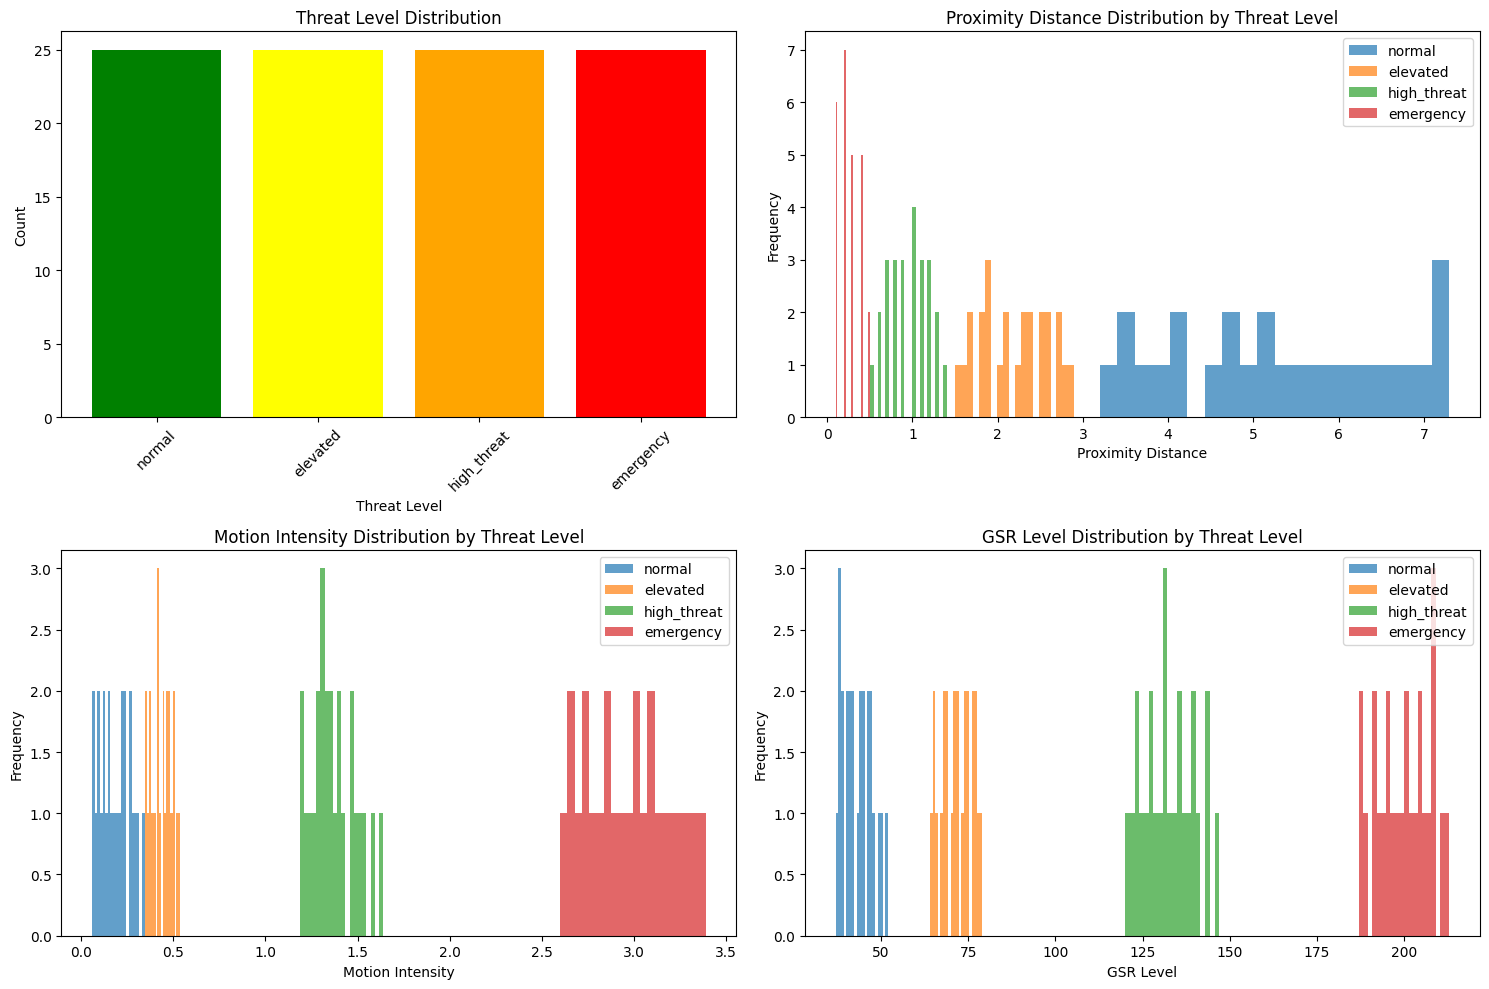

Training set: 80 samples
Test set: 20 samples

3. Building sequential stage models...
Training Stage 1: Proximity Detection...
Training Stage 2: Motion Analysis...
Training Stage 3: Stress Detection...
Training Stage 4: Voice Analysis...

4. Evaluating sequential processing...
Evaluating sequential model...
=== SEQUENTIAL PROCESSING ANALYSIS ===
Overall Accuracy: 0.7500
Precision: 0.6250
Recall: 0.7500
F1-Score: 0.6667
Average Stages Processed: 2.75

Stage Usage Frequency:
  Proximity: 100.0%
  Motion: 75.0%
  Stress: 50.0%
  Voice: 50.0%

Processing Efficiency:
  1 Stage (Early termination): 25.0%
  2 Stages: 25.0%
  3 Stages: 0.0%
  4 Stages (Full pipeline): 50.0%
5. Generating efficiency visualizations...


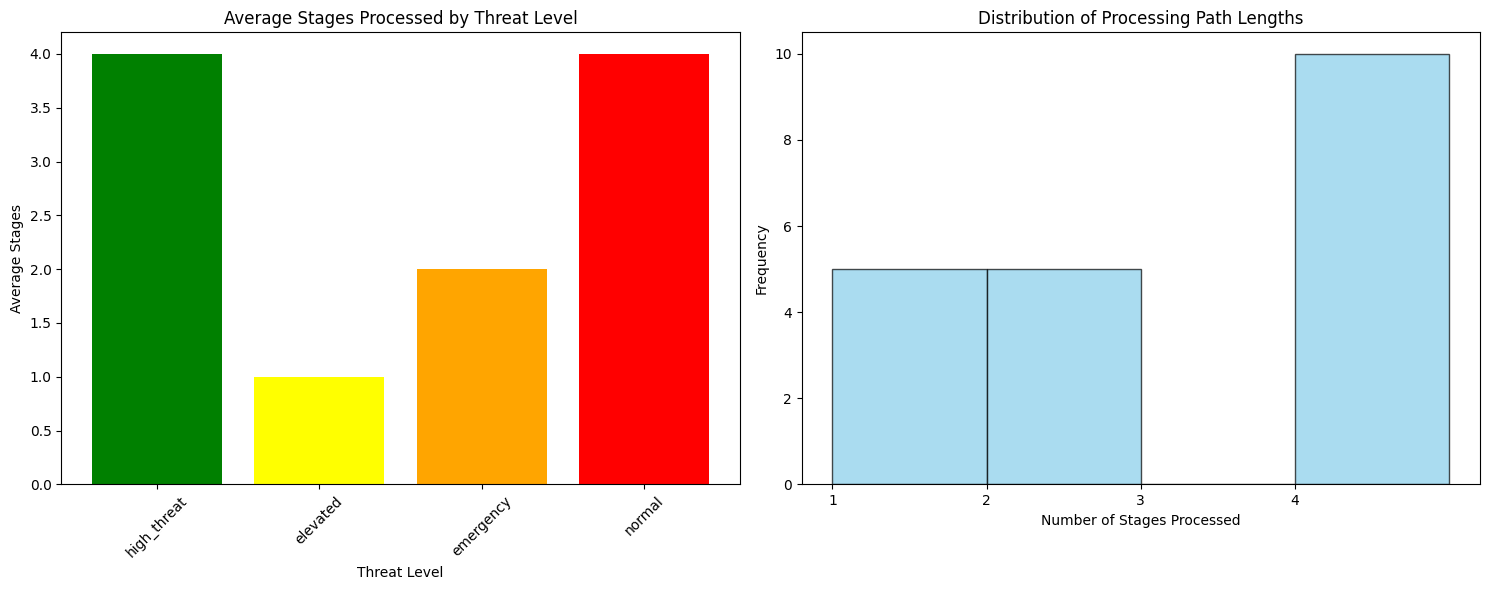

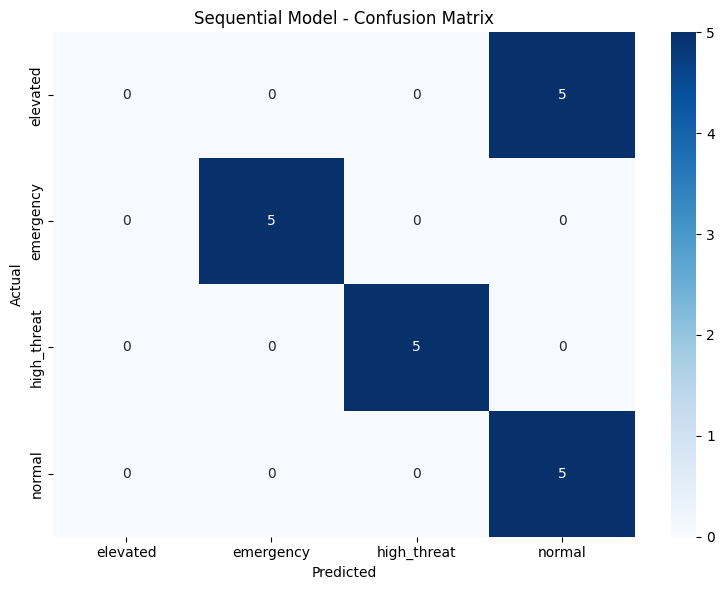


6. Detailed Classification Report:
              precision    recall  f1-score   support

    elevated       0.00      0.00      0.00         5
   emergency       1.00      1.00      1.00         5
 high_threat       1.00      1.00      1.00         5
      normal       0.50      1.00      0.67         5

    accuracy                           0.75        20
   macro avg       0.62      0.75      0.67        20
weighted avg       0.62      0.75      0.67        20


7. Example Sequential Predictions:
--------------------------------------------------

Sample 1:
  Actual: high_threat
  Predicted: high_threat
  Processing Path: proximity → motion → stress → voice
  Stages Used: 4/4
  Scenario: Serial killer following victim
    Proximity: high_threat (confidence: 1.000, raw: 1.10)
    Motion: high_threat (confidence: 1.000, raw: 1.28)
    Stress: high_threat (confidence: 0.900, raw: 127.00)
    Voice: high_threat (confidence: 0.980, raw: 73.00)

Sample 2:
  Actual: elevated
  Predicted:

In [ ]:
if __name__ == "__main__":
    test_csv = 'test.csv'
    model, results = main(test_csv)